In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
downloaded = drive.CreateFile({'id':'1nNpYncy431sKSyaL3nkbGw7LImAMDD2g'}) 
downloaded.GetContentFile('AviationData.csv') 

The above is just to upload the data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
import datetime 
sb.set() 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Aviation data is not UTF-8, so we need to use 'latin_1' to encode the data
aviationdata = pd.read_csv('AviationData.csv', encoding='latin_1')



# Problem Formulation & Data Preparation

For our team, we've decided to think about <b>the fatality of the accidents.</b> We'll be choosing a few select variables - how we come up with these variables will be detailed here as well! Ultimately, we would like to come up with a model <b>to predict whether or not an accident will be fatal.</b> [Problem Statement]

We will be looking at <b>Event Date, Location (Latitude & Longitude), Weather Condition, Broad Phase of Flight, Purpose of Flight, Amateur Built?, Number of Engines</b> as potential predictors against <b>Injury Severity</b>

In [ ]:
# here I get rid of all non-Accident and non-Airplane data
aviationdata_cleaned = aviationdata.loc[(aviationdata['Aircraft.Category'] == 'Airplane') & (aviationdata['Investigation.Type'] == 'Accident'), :]
# keeping only the useful data that we are using
aviationdata_cleaned = pd.DataFrame(aviationdata_cleaned[['Injury.Severity', 'Event.Date', 'Event.Id', 'Latitude', 'Longitude', 'Aircraft.Damage',
                                                          'Amateur.Built','Number.of.Engines','Weather.Condition', 'Purpose.of.Flight','Broad.Phase.of.Flight']])
# dropping all the rows which have any null values in any of the above columns
aviationdata_cleaned = aviationdata_cleaned.dropna()

# let's assume that if the data says the accident is unknown (or fatal(x)), the accident did result in some deaths - i.e. was fatal
aviationdata_cleaned.loc[aviationdata_cleaned['Injury.Severity'] != 'Non-Fatal', 'Injury.Severity'] = 'Fatal'



# if ready to use this 'cleaned' data, uncomment the next line
aviationdata = aviationdata_cleaned
aviationdata.head()

##### The following is to be used for data with a 1:1 ratio of fatalities:non-fatalities ###########

data1 = aviationdata[aviationdata['Injury.Severity'] == 'Fatal'] 
data2 = aviationdata[aviationdata['Injury.Severity'] == 'Non-Fatal'] 
data1_train, data1_test = train_test_split(data1, train_size = 500 , test_size =500)
data2_train, data2_test = train_test_split(data2, train_size = 500, test_size = 500  )
data1_train['index'] = data1_train.index 
data2_train['index'] = data2_train.index 
data1_train_reindex = data1_train.reset_index(drop = True)
data2_train_reindex = data2_train.reset_index(drop = True)
data2_train_reindex.index += 500
data2_train_reindex
frames = [data1_train_reindex,data2_train_reindex]
new_db = pd.concat(frames)
aviationdata = new_db

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
aviationdata

,Injury.Severity,Event.Date,Event.Id,Latitude,Longitude,Aircraft.Damage,Amateur.Built,Number.of.Engines,Weather.Condition,Purpose.of.Flight,Broad.Phase.of.Flight,index
0,Fatal,2014-03-26,20140327X61657,17.975278,-66.020834,Substantial,Yes,1.0,VMC,Personal,APPROACH,9225
1,Fatal,2014-06-09,20140609X22015,28.368056,-80.687500,Destroyed,No,1.0,VMC,Personal,MANEUVERING,8881
2,Fatal,2011-05-20,20110523X00308,36.419723,-105.287222,Substantial,No,1.0,IMC,Personal,CRUISE,14162
3,Fatal,2015-03-27,20150327X35752,46.718056,-94.376111,Substantial,No,1.0,VMC,Personal,TAKEOFF,7652
4,Fatal,2009-10-27,20091028X13928,45.140555,-84.667223,Destroyed,No,1.0,VMC,Personal,MANEUVERING,16819
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Non-Fatal,2012-08-26,20120826X71001,39.553889,-104.733889,Substantial,Yes,1.0,VMC,Personal,CLIMB,11629
996,Non-Fatal,2009-07-12,20090713X90753,30.200000,-95.551389,Substantial,No,1.0,VMC,Personal,MANEUVERING,17463
997,Non-Fatal,2006-02-01,20060327X00353,36.048333,-79.474723,Substantial,No,2.0,VMC,Executive/Corporate,LANDING,24095
998,Non-Fatal,2012-09-03,20120903X33429,47.083333,-122.466667,Substantial,No,2.0,VMC,Personal,LANDING,11558


# Statistical Description & Exploratory Analysis

In [ ]:
print("Data type : ", type(aviationdata))
print("Data dims : ", aviationdata.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (1000, 12)


In [ ]:
aviationdata.info()
# we have a consistent number of 13907 non-null objects/data to work with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Injury.Severity        1000 non-null   object 
 1   Event.Date             1000 non-null   object 
 2   Event.Id               1000 non-null   object 
 3   Latitude               1000 non-null   float64
 4   Longitude              1000 non-null   float64
 5   Aircraft.Damage        1000 non-null   object 
 6   Amateur.Built          1000 non-null   object 
 7   Number.of.Engines      1000 non-null   float64
 8   Weather.Condition      1000 non-null   object 
 9   Purpose.of.Flight      1000 non-null   object 
 10  Broad.Phase.of.Flight  1000 non-null   object 
 11  index                  1000 non-null   int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 93.9+ KB


# Pattern Recognition & Analytic Visualization

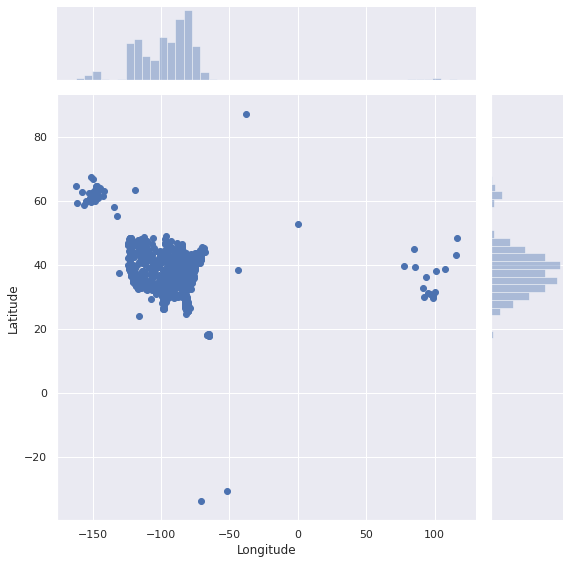

In [ ]:
# Use a joint plot to see the location of the accident
sb.jointplot(x = (aviationdata['Longitude']), y = (aviationdata['Latitude']), height = 8)

In [ ]:
# installing geopandas
!pip install -U -q geopandas

     |████████████████████████████████| 931kB 9.7MB/s 
     |████████████████████████████████| 14.7MB 199kB/s 
     |████████████████████████████████| 10.4MB 192kB/s 


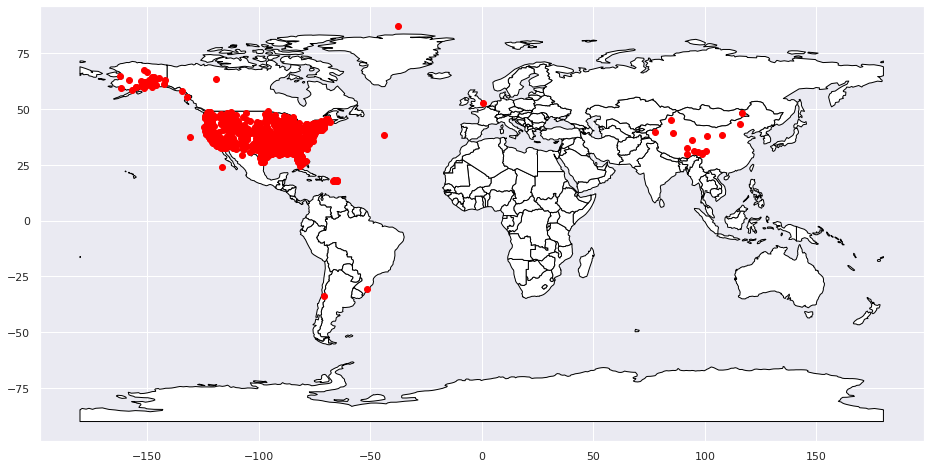

In [ ]:
# let's try to visualize this on a map
import geopandas as gpd

geodf = gpd.GeoDataFrame(
    aviationdata, geometry=gpd.points_from_xy(aviationdata.Longitude, aviationdata.Latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black', figsize = (20,8))

geodf.plot(ax = ax, color ='red')

In [ ]:
# Extract some columns to analyze
extractData = pd.DataFrame(aviationdata[['Aircraft.Damage','Event.Date' ,'Amateur.Built', 'Weather.Condition', 'Number.of.Engines', 'Purpose.of.Flight','Broad.Phase.of.Flight', 'Injury.Severity']])
extractData.head()

,Aircraft.Damage,Event.Date,Amateur.Built,Weather.Condition,Number.of.Engines,Purpose.of.Flight,Broad.Phase.of.Flight,Injury.Severity
0,Substantial,2014-03-26,Yes,VMC,1.0,Personal,APPROACH,Fatal
1,Destroyed,2014-06-09,No,VMC,1.0,Personal,MANEUVERING,Fatal
2,Substantial,2011-05-20,No,IMC,1.0,Personal,CRUISE,Fatal
3,Substantial,2015-03-27,No,VMC,1.0,Personal,TAKEOFF,Fatal
4,Destroyed,2009-10-27,No,VMC,1.0,Personal,MANEUVERING,Fatal


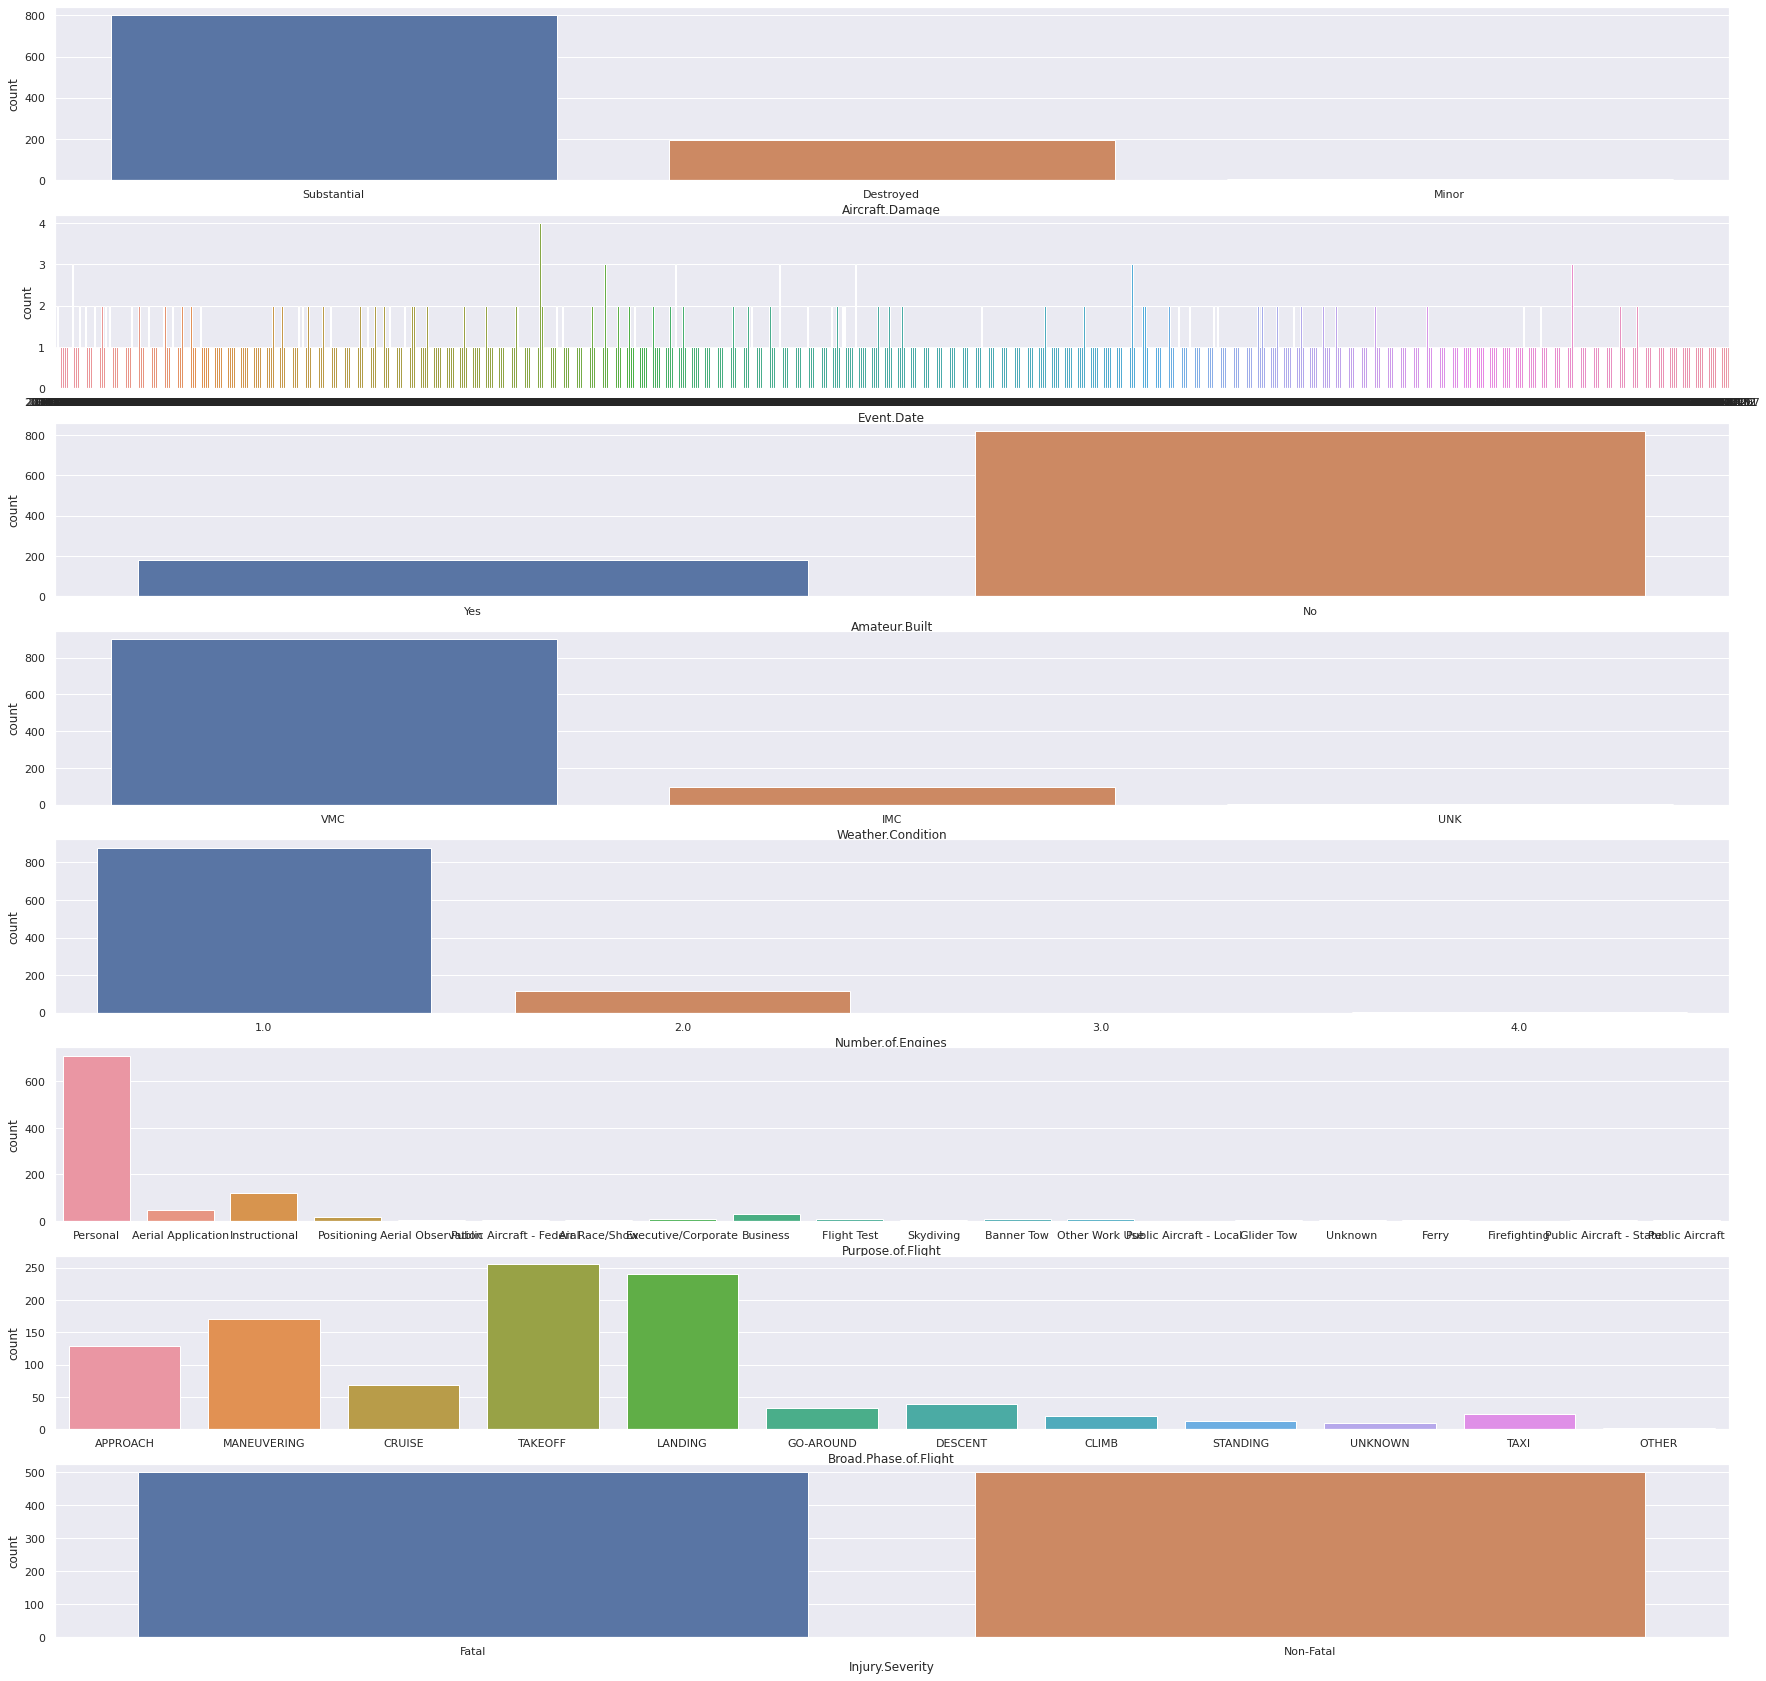

In [ ]:
# Bar plot
f, axes = plt.subplots(8, 1, figsize=(30, 30))
i = 0
for var in extractData:
  sb.countplot(x = var, data = extractData, ax = axes[i])
  i += 1

# Observations from the data

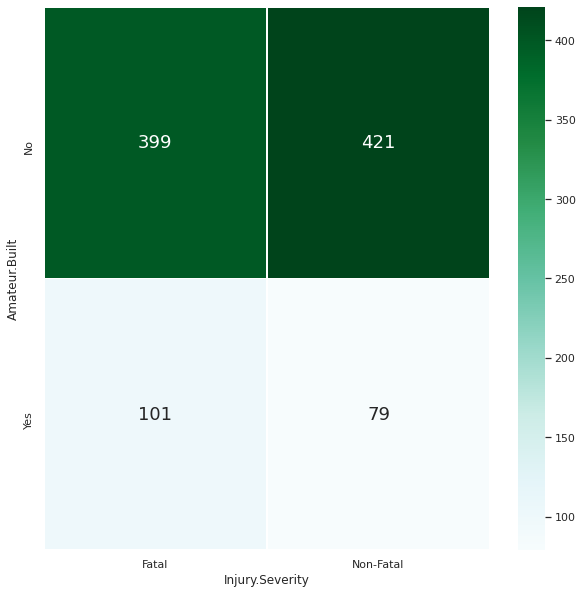

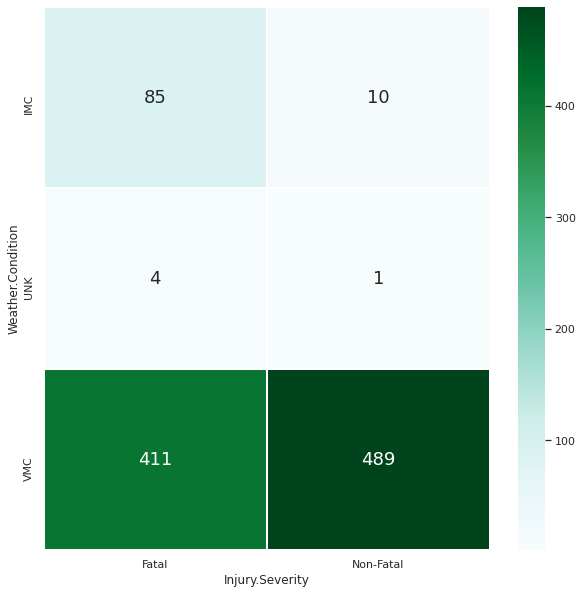

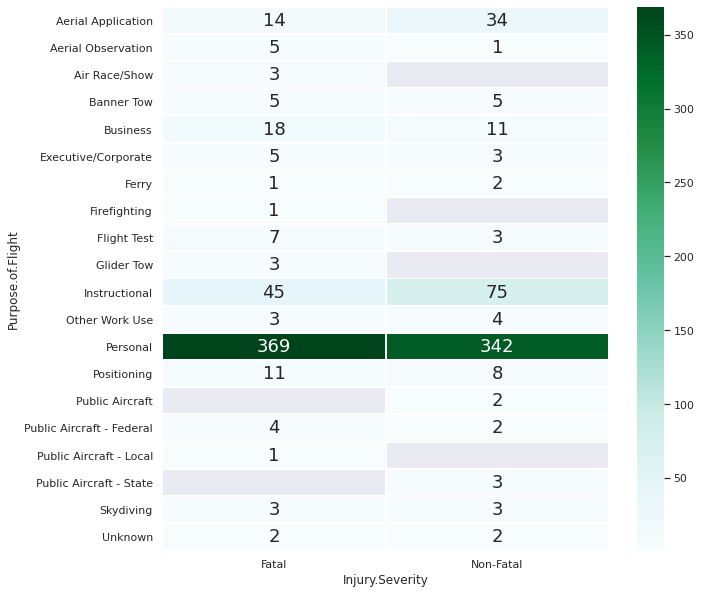

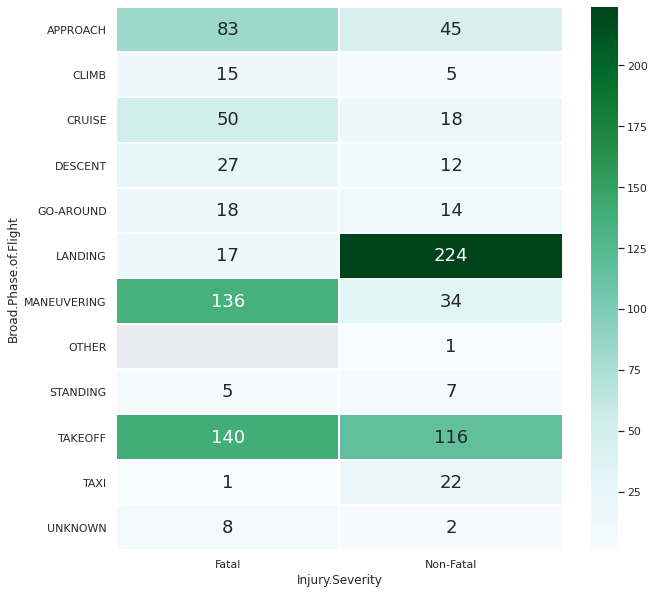

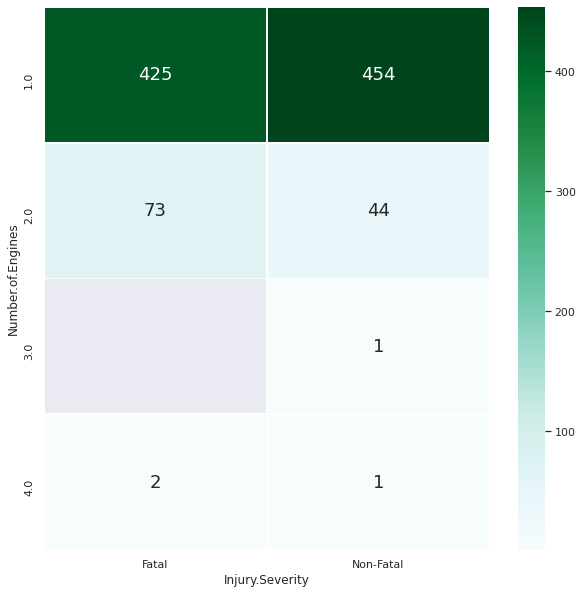

In [ ]:
################ THIS CONTAINS THE OLD 'RUNNING ALL VARIABLES AGAINST INJURY SEVERITY' CODE ########################
# Use these variable against 'Injury Severity' to plot heat map
for var in ['Amateur.Built', 'Weather.Condition','Purpose.of.Flight','Broad.Phase.of.Flight','Number.of.Engines']:
    f, axes = plt.subplots(1, 1, figsize=(10, 10))
    sb.heatmap(extractData.groupby([var, 'Injury.Severity']).size().unstack(), 
               linewidths = 1, fmt = 'g', annot = True, annot_kws = {"size": 18}, cmap = "BuGn")
###################################### END ########################################################################

In [ ]:
aviationdata['Event.Date'] = pd.to_datetime(aviationdata['Event.Date'])
aft82 = aviationdata[aviationdata['Event.Date'] >= '1982-1-1']
accidentsByMonth = aft82.groupby(pd.Grouper(key='Event.Date',freq='M')).count()

In [ ]:
aviationdata['month'] = pd.DatetimeIndex(aviationdata['Event.Date']).month

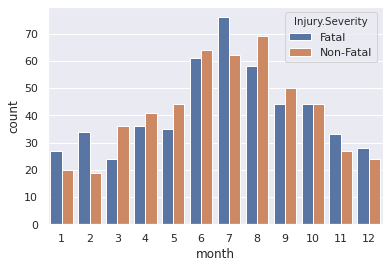

In [ ]:
sb.countplot(x = 'month',hue = 'Injury.Severity', data = aviationdata)

We can see that the majority of the accidents (both Non-Fatal and Fatal) occur during the middle of the year (July)

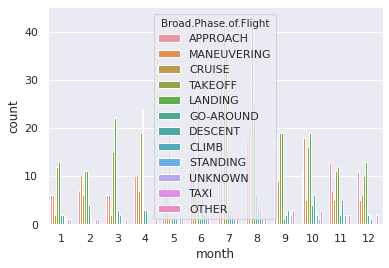

In [ ]:
sb.countplot(x = 'month',hue = 'Broad.Phase.of.Flight', data = aviationdata)

In [ ]:
aviationdata['month'].value_counts()

7     138
8     127
6     125
9      94
10     88
5      79
4      77
11     60
3      60
2      53
12     52
1      47
Name: month, dtype: int64

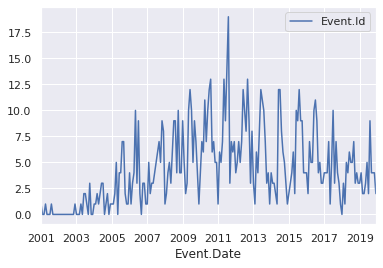

In [ ]:
accidentsByMonth.plot(y='Event.Id')

# Univariate Models Comparing Classification Accuracy

In [ ]:
# classification model 1

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [ ]:
predictor = pd.DataFrame(aviationdata[['Aircraft.Damage', 'Amateur.Built', 'Weather.Condition', 'Purpose.of.Flight', 'Broad.Phase.of.Flight','month','Number.of.Engines']])
predictor.head()

,Aircraft.Damage,Amateur.Built,Weather.Condition,Purpose.of.Flight,Broad.Phase.of.Flight,month,Number.of.Engines
0,Substantial,Yes,VMC,Personal,APPROACH,3,1.0
1,Destroyed,No,VMC,Personal,MANEUVERING,6,1.0
2,Substantial,No,IMC,Personal,CRUISE,5,1.0
3,Substantial,No,VMC,Personal,TAKEOFF,3,1.0
4,Destroyed,No,VMC,Personal,MANEUVERING,10,1.0


In [ ]:
temp_dataframe = pd.DataFrame({"temp":[]})
predictor_num = pd.DataFrame(aviationdata[['month','Number.of.Engines']])
for pred in predictor:
    temp_list = []
    temp_dataframe = pd.DataFrame({pred:[]})
    count = 0
    for var in predictor[pred]:
        if not(var in temp_list):
            temp_list.append(var)
        temp_dataframe.loc[count] = [temp_list.index(var)]
        count+=1
    predictor_num[pred] = temp_dataframe
count = 0
injury_num = pd.DataFrame({"injury":[]})
for var in aviationdata['Injury.Severity']:
    if var == 'Non-Fatal':
        injury_num.loc[count] = [0]
    elif var == 'Fatal':
        injury_num.loc[count] = [1]
    count += 1
predictor_num['Injury.Severity'] = injury_num
predictor_num = predictor_num.astype(int)
predictor_num


,month,Number.of.Engines,Aircraft.Damage,Amateur.Built,Weather.Condition,Purpose.of.Flight,Broad.Phase.of.Flight,Injury.Severity
0,0,0,0,0,0,0,0,1
1,1,0,1,1,0,0,1,1
2,2,0,0,1,1,0,2,1
3,0,0,0,1,0,0,3,1
4,3,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...
995,8,0,0,0,0,0,7,0
996,6,0,0,1,0,0,1,0
997,11,1,0,1,0,7,4,0
998,4,1,0,1,0,0,4,0


In [ ]:
temp_dataframe = pd.DataFrame({"temp":[]})
predictor_num = pd.DataFrame({"Index":[n for n in range(0, 1000, 1)]})
for pred in predictor:
    temp_list = []
    temp_dataframe = pd.DataFrame({pred:[]})
    count = 0
    for var in predictor[pred]:
        if not(var in temp_list):
            temp_list.append(var)
        temp_dataframe.loc[count] = [temp_list.index(var)]
        count+=1
    predictor_num[pred] = temp_dataframe
count = 0
injury_num = pd.DataFrame({"injury":[]})
for var in aviationdata['Injury.Severity']:
    if var == 'Non-Fatal':
        injury_num.loc[count] = [0]
    elif var == 'Fatal':
        injury_num.loc[count] = [1]
    count += 1
predictor_num['Injury.Severity'] = injury_num
predictor_num

,Index,Aircraft.Damage,Amateur.Built,Weather.Condition,Purpose.of.Flight,Broad.Phase.of.Flight,month,Number.of.Engines,Injury.Severity
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,2,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0
3,3,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0
4,4,1.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
995,995,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0
996,996,0.0,1.0,0.0,0.0,1.0,6.0,0.0,0.0
997,997,0.0,1.0,0.0,7.0,4.0,11.0,1.0,0.0
998,998,0.0,1.0,0.0,0.0,4.0,4.0,1.0,0.0


In [ ]:
X_train_damageNB, X_test_damageNB, y_train_injuryNB1, y_test_injuryNB1 = train_test_split(pd.DataFrame(predictor_num['Aircraft.Damage']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)
X_train_amateurNB, X_test_amateurNB, y_train_injuryNB2, y_test_injuryNB2 = train_test_split(pd.DataFrame(predictor_num['Amateur.Built']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)
X_train_weatherNB, X_test_weatherNB, y_train_injuryNB3, y_test_injuryNB3 = train_test_split(pd.DataFrame(predictor_num['Weather.Condition']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)
X_train_enginenumNB, X_test_enginenumNB, y_train_injuryNB4, y_test_injuryNB4 = train_test_split(pd.DataFrame(predictor_num['Number.of.Engines']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)
X_train_purposeNB, X_test_purposeNB, y_train_injuryNB5, y_test_injuryNB5 = train_test_split(pd.DataFrame(predictor_num['Purpose.of.Flight']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)
X_train_broadNB, X_test_broadNB, y_train_injuryNB6, y_test_injuryNB6 = train_test_split(pd.DataFrame(predictor_num['Broad.Phase.of.Flight']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)
X_train_monthNB, X_test_monthNB, y_train_injuryNB7, y_test_injuryNB7 = train_test_split(pd.DataFrame(predictor_num['month']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Aircraft Damage

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6675

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.685

              precision    recall  f1-score   support

         0.0       0.60      0.97      0.74       394
         1.0       0.93      0.37      0.53       406

    accuracy                           0.67       800
   macro avg       0.76      0.67      0.64       800
weighted avg       0.77      0.67      0.64       800

[[382  12]
 [254 152]]
              precision    recall  f1-score   support

         0.0       0.63      0.99      0.77       106
         1.0       0.97      0.34      0.50        94

    accuracy                           0.69       200
   macro avg       0.80      0.67      0.64       200
weighted avg       0.79      0.69      0.64       200

[[105   1]
 [ 62  32]]


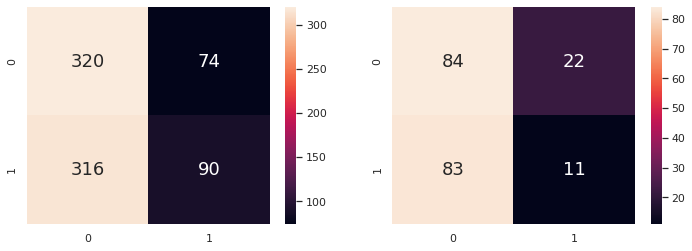

In [ ]:
print("Aircraft Damage")
print()
model_damage = CategoricalNB()
model_damage.fit(X_train_damageNB, y_train_injuryNB1.values.ravel())
y_damage_train_pred = model_damage.predict(X_train_damageNB)
y_damage_test_pred = model_damage.predict(X_test_damageNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB1, y_damage_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB1, y_damage_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB1, y_damage_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB1, y_damage_train_pred))

print(metrics.classification_report(y_test_injuryNB1, y_damage_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB1, y_damage_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB2, y_damage_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB2, y_damage_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Amateur Built

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.50875

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.575

              precision    recall  f1-score   support

         0.0       0.50      0.83      0.62       394
         1.0       0.54      0.20      0.29       406

    accuracy                           0.51       800
   macro avg       0.52      0.51      0.46       800
weighted avg       0.52      0.51      0.45       800

[[327  67]
 [326  80]]
              precision    recall  f1-score   support

         0.0       0.56      0.89      0.69       106
         1.0       0.64      0.22      0.33        94

    accuracy                           0.57       200
   macro avg       0.60      0.56      0.51       200
weighted avg       0.60      0.57      0.52       200

[[94 12]
 [73 21]]


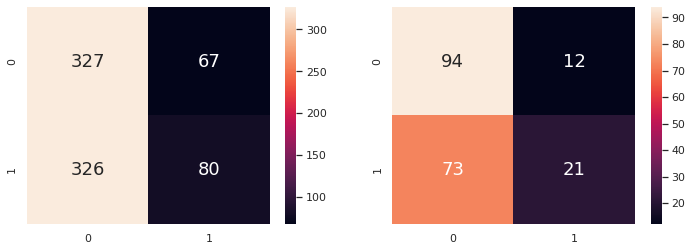

In [ ]:
print("Amateur Built")
print()
model_amateur = CategoricalNB()
model_amateur.fit(X_train_amateurNB, y_train_injuryNB2.values.ravel())
y_amateur_train_pred = model_amateur.predict(X_train_amateurNB)
y_amateur_test_pred = model_amateur.predict(X_test_amateurNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB2, y_amateur_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB2, y_amateur_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB2, y_amateur_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB2, y_amateur_train_pred))

print(metrics.classification_report(y_test_injuryNB2, y_amateur_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB2, y_amateur_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB2, y_amateur_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB2, y_amateur_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Weather Condition

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.585

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.55

              precision    recall  f1-score   support

         0.0       0.55      0.98      0.70       406
         1.0       0.88      0.18      0.30       394

    accuracy                           0.58       800
   macro avg       0.71      0.58      0.50       800
weighted avg       0.71      0.58      0.51       800

[[396  10]
 [322  72]]
              precision    recall  f1-score   support

         0.0       0.51      0.99      0.67        94
         1.0       0.94      0.16      0.27       106

    accuracy                           0.55       200
   macro avg       0.73      0.57      0.47       200
weighted avg       0.74      0.55      0.46       200

[[93  1]
 [89 17]]


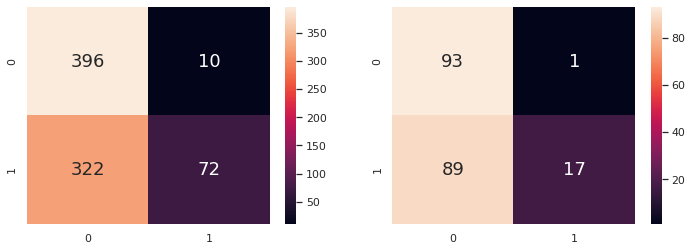

In [ ]:
print("Weather Condition")
print()
model_weather = CategoricalNB()
model_weather.fit(X_train_weatherNB, y_train_injuryNB3.values.ravel())
y_weather_train_pred = model_weather.predict(X_train_weatherNB)
y_weather_test_pred = model_weather.predict(X_test_weatherNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB3, y_weather_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB3, y_weather_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB3, y_weather_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB3, y_weather_train_pred))

print(metrics.classification_report(y_test_injuryNB3, y_weather_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB3, y_weather_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB3, y_weather_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB3, y_weather_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Number of Engines

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.54

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.485

              precision    recall  f1-score   support

         0.0       0.53      0.92      0.67       406
         1.0       0.64      0.15      0.24       394

    accuracy                           0.54       800
   macro avg       0.58      0.53      0.46       800
weighted avg       0.58      0.54      0.46       800

[[373  33]
 [335  59]]
              precision    recall  f1-score   support

         0.0       0.47      0.88      0.62        94
         1.0       0.56      0.13      0.21       106

    accuracy                           0.48       200
   macro avg       0.52      0.51      0.42       200
weighted avg       0.52      0.48      0.40       200

[[83 11]
 [92 14]]


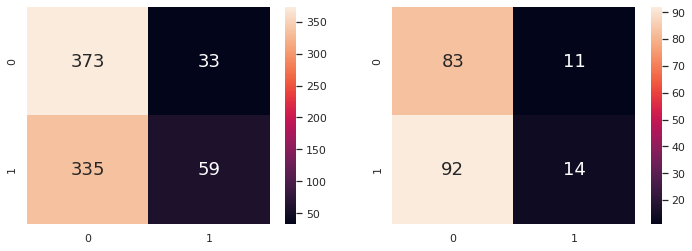

In [ ]:
print("Number of Engines")
print()
model_enginenum = CategoricalNB()
model_enginenum.fit(X_train_enginenumNB, y_train_injuryNB4.values.ravel())
y_enginenum_train_pred = model_enginenum.predict(X_train_enginenumNB)
y_enginenum_test_pred = model_enginenum.predict(X_test_enginenumNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB4, y_enginenum_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB4, y_enginenum_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB4, y_enginenum_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB4, y_enginenum_train_pred))

print(metrics.classification_report(y_test_injuryNB4, y_enginenum_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB4, y_enginenum_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB4, y_enginenum_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB4, y_enginenum_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Purpose of Flight

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.56375

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.525

              precision    recall  f1-score   support

         0.0       0.64      0.25      0.35       390
         1.0       0.55      0.87      0.67       410

    accuracy                           0.56       800
   macro avg       0.59      0.56      0.51       800
weighted avg       0.59      0.56      0.52       800

[[ 96 294]
 [ 55 355]]
              precision    recall  f1-score   support

         0.0       0.76      0.20      0.32       110
         1.0       0.49      0.92      0.64        90

    accuracy                           0.53       200
   macro avg       0.62      0.56      0.48       200
weighted avg       0.64      0.53      0.46       200

[[22 88]
 [ 7 83]]


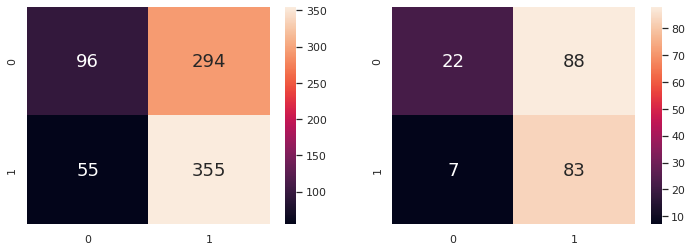

In [ ]:
print("Purpose of Flight")
print()
model_purpose = CategoricalNB()
model_purpose.fit(X_train_purposeNB, y_train_injuryNB5.values.ravel())
y_purpose_train_pred = model_purpose.predict(X_train_purposeNB)
y_purpose_test_pred = model_purpose.predict(X_test_purposeNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB5, y_purpose_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB5, y_purpose_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB5, y_purpose_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB5, y_purpose_train_pred))

print(metrics.classification_report(y_test_injuryNB5, y_purpose_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB5, y_purpose_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB5, y_purpose_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB5, y_purpose_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [ ]:
print("Broad Phase of Flight")
print()
model_broad = CategoricalNB()
model_broad.fit(X_train_broadNB, y_train_injuryNB6.values.ravel())
y_broad_train_pred = model_broad.predict(X_train_broadNB)
y_broad_test_pred = model_broad.predict(X_test_broadNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB6, y_broad_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB6, y_broad_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB6, y_broad_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB6, y_broad_train_pred))

print(metrics.classification_report(y_test_injuryNB6, y_broad_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB6, y_broad_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB6, y_broad_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB6, y_broad_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Broad Phase of Flight



IndexError: ignored

Month

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5575

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.465

              precision    recall  f1-score   support

         0.0       0.55      0.54      0.54       394
         1.0       0.56      0.58      0.57       406

    accuracy                           0.56       800
   macro avg       0.56      0.56      0.56       800
weighted avg       0.56      0.56      0.56       800

[[211 183]
 [171 235]]
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50       106
         1.0       0.43      0.43      0.43        94

    accuracy                           0.47       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.47      0.46       200

[[53 53]
 [54 40]]


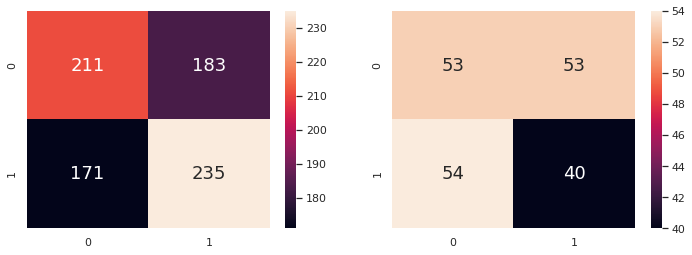

In [ ]:
print("Month")
print()
model_month = CategoricalNB()
model_month.fit(X_train_monthNB, y_train_injuryNB7.values.ravel())
y_month_train_pred = model_month.predict(X_train_monthNB)
y_month_test_pred = model_month.predict(X_test_monthNB)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y_train_injuryNB7, y_month_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y_test_injuryNB7, y_month_test_pred))
print()

print(metrics.classification_report(y_train_injuryNB7, y_month_train_pred))
print(metrics.confusion_matrix(y_train_injuryNB7, y_month_train_pred))

print(metrics.classification_report(y_test_injuryNB7, y_month_test_pred))
print(metrics.confusion_matrix(y_test_injuryNB7, y_month_test_pred))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_injuryNB7, y_month_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_injuryNB7, y_month_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# uni Naive Bayes end

In [ ]:
# classification model 2

In [ ]:
# preparing data for fitting model
aviationdata['Injury.Severity'] = aviationdata['Injury.Severity'].astype('category')
aviationdata['Is.Fatal'] = aviationdata['Injury.Severity'].map({"Non-Fatal": 0, "Fatal": 1})
aviationdata['Is.Visual'] = aviationdata['Weather.Condition'].map({"IMC": 0, "VMC": 1, "UNK": 0})
aviationdata['Is.AmBuilt'] = aviationdata['Amateur.Built'].map({"No": 0, "Yes": 1})
aviationdata['Number.of.Engines'] = aviationdata['Number.of.Engines'].astype('int64')

In [ ]:
filterdata = pd.get_dummies(aviationdata, columns=['Aircraft.Damage','Broad.Phase.of.Flight'], prefix=['Damage','Phase'])
filterdata = filterdata.drop(['Injury.Severity','Event.Date','Event.Id','Amateur.Built','Weather.Condition','Purpose.of.Flight'], axis=1)
filterdata

,Latitude,Longitude,Number.of.Engines,index,geometry,month,Is.Fatal,Is.Visual,Is.AmBuilt,Damage_Destroyed,Damage_Minor,Damage_Substantial,Phase_APPROACH,Phase_CLIMB,Phase_CRUISE,Phase_DESCENT,Phase_GO-AROUND,Phase_LANDING,Phase_MANEUVERING,Phase_OTHER,Phase_STANDING,Phase_TAKEOFF,Phase_TAXI,Phase_UNKNOWN
0,17.975278,-66.020834,1,9225,POINT (-66.02083 17.97528),3,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,28.368056,-80.687500,1,8881,POINT (-80.68750 28.36806),6,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,36.419723,-105.287222,1,14162,POINT (-105.28722 36.41972),5,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,46.718056,-94.376111,1,7652,POINT (-94.37611 46.71806),3,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,45.140555,-84.667223,1,16819,POINT (-84.66722 45.14055),10,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.553889,-104.733889,1,11629,POINT (-104.73389 39.55389),8,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
996,30.200000,-95.551389,1,17463,POINT (-95.55139 30.20000),7,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
997,36.048333,-79.474723,2,24095,POINT (-79.47472 36.04833),2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
998,47.083333,-122.466667,2,11558,POINT (-122.46667 47.08333),9,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
data1_train, data1_test = train_test_split(filterdata, train_size = 800 , test_size =200)
data1_train['index'] = data1_train.index 
data1_train_reindex = data1_train.reset_index(drop = True)
data1_train_reindex

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,Number.of.Engines,index,geometry,month,Is.Fatal,Is.Visual,Is.AmBuilt,Damage_Destroyed,Damage_Minor,Damage_Substantial,Phase_APPROACH,Phase_CLIMB,Phase_CRUISE,Phase_DESCENT,Phase_GO-AROUND,Phase_LANDING,Phase_MANEUVERING,Phase_OTHER,Phase_STANDING,Phase_TAKEOFF,Phase_TAXI,Phase_UNKNOWN
0,27.711944,-82.282778,1,548,POINT (-82.28278 27.71194),12,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,47.465000,-122.568334,1,914,POINT (-122.56833 47.46500),6,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,34.084166,-117.763889,1,22,POINT (-117.76389 34.08417),11,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,31.302500,-82.280000,1,155,POINT (-82.28000 31.30250),10,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,40.496111,-88.868056,2,467,POINT (-88.86806 40.49611),4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,61.180000,-149.971945,1,605,POINT (-149.97195 61.18000),6,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
796,30.678611,-88.263611,1,294,POINT (-88.26361 30.67861),2,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
797,30.866945,96.706944,1,834,POINT (96.70694 30.86695),8,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
798,34.000278,-116.778889,2,112,POINT (-116.77889 34.00028),2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
data1_test['index'] = data1_test.index 
data1_test_reindex = data1_test.reset_index(drop = True)
data1_test_reindex

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,Number.of.Engines,index,geometry,month,Is.Fatal,Is.Visual,Is.AmBuilt,Damage_Destroyed,Damage_Minor,Damage_Substantial,Phase_APPROACH,Phase_CLIMB,Phase_CRUISE,Phase_DESCENT,Phase_GO-AROUND,Phase_LANDING,Phase_MANEUVERING,Phase_OTHER,Phase_STANDING,Phase_TAKEOFF,Phase_TAXI,Phase_UNKNOWN
0,43.565833,-116.221667,2,538,POINT (-116.22167 43.56583),5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,30.477778,-98.121111,1,905,POINT (-98.12111 30.47778),12,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,43.980278,-88.557500,1,694,POINT (-88.55750 43.98028),7,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,33.091666,-80.309444,1,982,POINT (-80.30944 33.09167),6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,26.608889,-80.083334,2,270,POINT (-80.08333 26.60889),9,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,40.442777,-76.441666,1,675,POINT (-76.44167 40.44278),9,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
196,36.650000,-83.216667,1,774,POINT (-83.21667 36.65000),7,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
197,42.035555,-86.468611,1,830,POINT (-86.46861 42.03556),8,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
198,32.033333,-96.142777,1,214,POINT (-96.14278 32.03333),3,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
newdb_train = data1_train_reindex
newdb_test = data1_test_reindex
newdb_test

,Latitude,Longitude,Number.of.Engines,index,geometry,month,Is.Fatal,Is.Visual,Is.AmBuilt,Damage_Destroyed,Damage_Minor,Damage_Substantial,Phase_APPROACH,Phase_CLIMB,Phase_CRUISE,Phase_DESCENT,Phase_GO-AROUND,Phase_LANDING,Phase_MANEUVERING,Phase_OTHER,Phase_STANDING,Phase_TAKEOFF,Phase_TAXI,Phase_UNKNOWN
0,43.565833,-116.221667,2,538,POINT (-116.22167 43.56583),5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,30.477778,-98.121111,1,905,POINT (-98.12111 30.47778),12,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,43.980278,-88.557500,1,694,POINT (-88.55750 43.98028),7,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,33.091666,-80.309444,1,982,POINT (-80.30944 33.09167),6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,26.608889,-80.083334,2,270,POINT (-80.08333 26.60889),9,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,40.442777,-76.441666,1,675,POINT (-76.44167 40.44278),9,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
196,36.650000,-83.216667,1,774,POINT (-83.21667 36.65000),7,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
197,42.035555,-86.468611,1,830,POINT (-86.46861 42.03556),8,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
198,32.033333,-96.142777,1,214,POINT (-96.14278 32.03333),3,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
X_train_cruise, X_test_cruise, y_train_fatal, y_test_fatal = train_test_split(pd.DataFrame(predictor_num['Broad.Phase.of.Flight']), pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
dectree3 = DecisionTreeClassifier(max_depth = 4)  
dectree3.fit(X_train_cruise,y_train_fatal) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

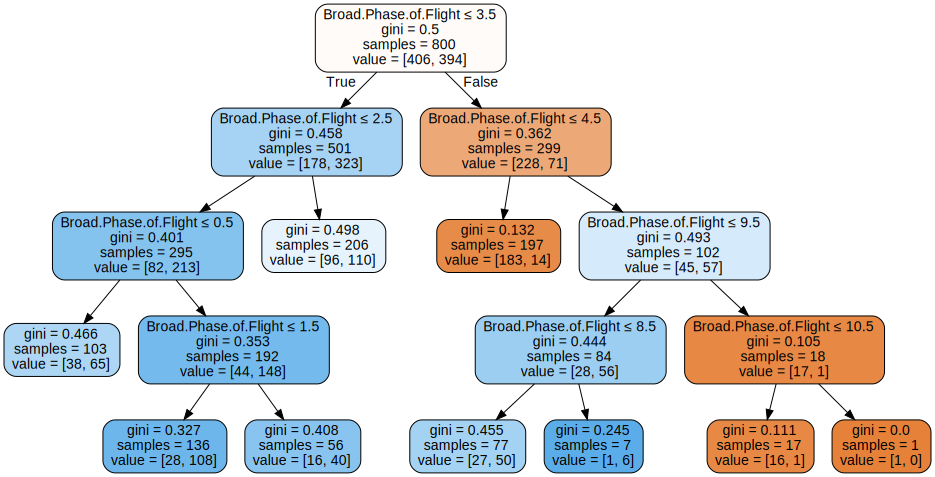

In [ ]:
from sklearn.tree import export_graphviz
treedot3 = export_graphviz(dectree3,                                      
                          feature_names = X_train_cruise.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
import graphviz
graphviz.Source(treedot3)

In [ ]:
damage_train_pred3 = dectree3.predict(y_train_fatal)
print("Classification Accuracy: ",dectree3.score(X_train_cruise,y_train_fatal ))

Classification Accuracy:  0.72375


In [ ]:
dectree1 = DecisionTreeClassifier(max_depth = 4)  
dectree1.fit(X_train_damageNB, y_train_injuryNB1.values.ravel())  

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

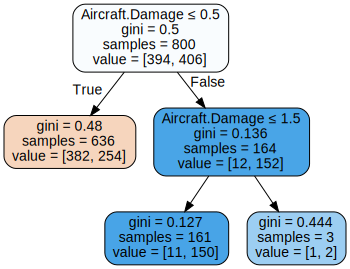

In [ ]:
from sklearn.tree import export_graphviz
treedot1 = export_graphviz(dectree1,                                      
                          feature_names = X_train_damageNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
import graphviz
graphviz.Source(treedot1)

In [ ]:
damage_train_pred1 = dectree1.predict(X_train_damageNB)
print("Classification Accuracy: ",dectree1.score(X_train_damageNB, y_train_injuryNB1))

Classification Accuracy:  0.6675


Aicraft Damage


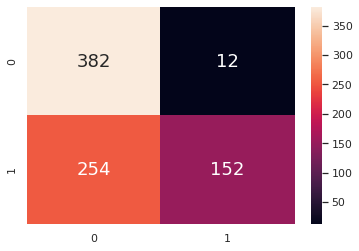

In [ ]:
print("Aicraft Damage")
sb.heatmap(confusion_matrix(y_train_injuryNB1,damage_train_pred1),
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
dectree_t1 = DecisionTreeClassifier(max_depth = 4)  
dectree_t1.fit(X_test_damageNB, y_test_injuryNB1.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

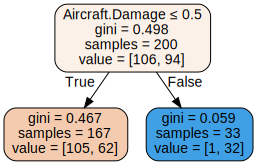

In [ ]:
from sklearn.tree import export_graphviz
treedot_t1 = export_graphviz(dectree_t1,                                      
                          feature_names = X_test_damageNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
import graphviz
graphviz.Source(treedot_t1)

In [ ]:
damage_train_pred_t1 = dectree_t1.predict(X_test_damageNB)
print("Classification Accuracy: ",dectree_t1.score(X_test_damageNB, y_test_injuryNB1))

Classification Accuracy:  0.685


Aicraft Damage Test Data


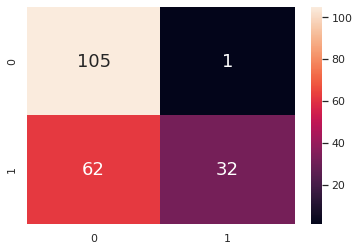

In [ ]:
print("Aicraft Damage Test Data")
sb.heatmap(confusion_matrix(y_test_injuryNB1,damage_train_pred_t1),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Weather Condition Decision Tree

In [ ]:
dectree2 = DecisionTreeClassifier(max_depth = 4)  
dectree2.fit(X_train_weatherNB, y_train_injuryNB3.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

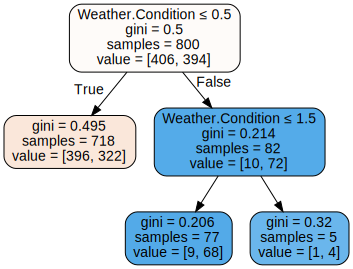

In [ ]:
treedot2 = export_graphviz(dectree2,                                      
                          feature_names = X_train_weatherNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot2)

In [ ]:
damage_train_pred2 = dectree2.predict(X_train_weatherNB)
print("Classification Accuracy: ",dectree2.score(X_train_weatherNB, y_train_injuryNB3.values))

Classification Accuracy:  0.585


Weather Condition


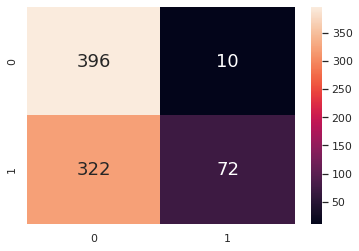

In [ ]:
print("Weather Condition")
sb.heatmap(confusion_matrix(y_train_injuryNB3,damage_train_pred2),
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
dectree_t2 = DecisionTreeClassifier(max_depth = 4)  
dectree_t2.fit(X_test_weatherNB, y_test_injuryNB3.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

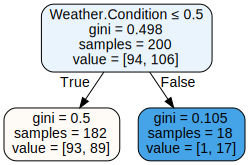

In [ ]:
treedot_t2 = export_graphviz(dectree_t2,                                      
                          feature_names = X_test_weatherNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot_t2)

In [ ]:
damage_test_pred2 = dectree_t2.predict(X_test_weatherNB)
print("Classification Accuracy: ",dectree_t2.score(X_test_weatherNB, y_test_injuryNB3.values))

Classification Accuracy:  0.55


Weather Condition Test Data


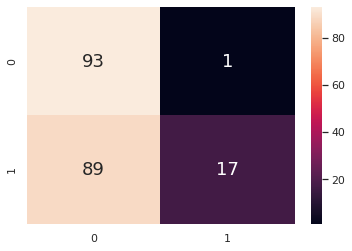

In [ ]:
print("Weather Condition Test Data")
sb.heatmap(confusion_matrix(y_test_injuryNB3,damage_test_pred2),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Amateur Built Decision Tree

In [ ]:
dectree4 = DecisionTreeClassifier(max_depth = 4)  
dectree4.fit(X_train_amateurNB, y_train_injuryNB2.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

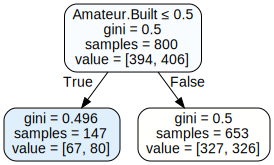

In [ ]:
treedot4 = export_graphviz(dectree4,                                      
                          feature_names = X_train_amateurNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot4)

In [ ]:
damage_train_pred4 = dectree4.predict(X_train_weatherNB)
print("Classification Accuracy: ",dectree4.score(X_train_weatherNB, y_train_injuryNB3.values))

Classification Accuracy:  0.415


Amatuer Built


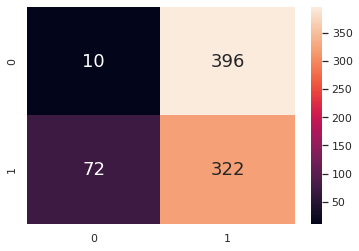

In [ ]:
print("Amatuer Built")
sb.heatmap(confusion_matrix(y_train_injuryNB3,damage_train_pred4),
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
dectree_t4 = DecisionTreeClassifier(max_depth = 4)  
dectree_t4.fit(X_test_amateurNB, y_test_injuryNB2.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

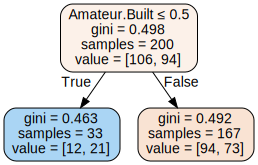

In [ ]:
treedot_t4 = export_graphviz(dectree_t4,                                      
                          feature_names = X_test_amateurNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot_t4)

In [ ]:
damage_test_pred4 = dectree_t4.predict(X_test_weatherNB)
print("Classification Accuracy: ",dectree_t4.score(X_test_weatherNB, y_test_injuryNB3.values))

Classification Accuracy:  0.45


Amatuer Built Test Data


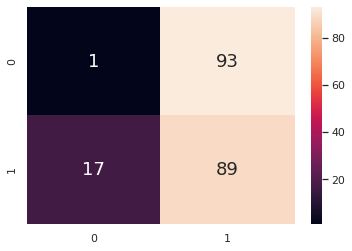

In [ ]:
print("Amatuer Built Test Data")
sb.heatmap(confusion_matrix(y_test_injuryNB3,damage_test_pred4),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Purpose of Flight Decision Tree

In [ ]:
dectree5 = DecisionTreeClassifier(max_depth = 4)  
dectree5.fit(X_train_purposeNB, y_train_injuryNB5.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

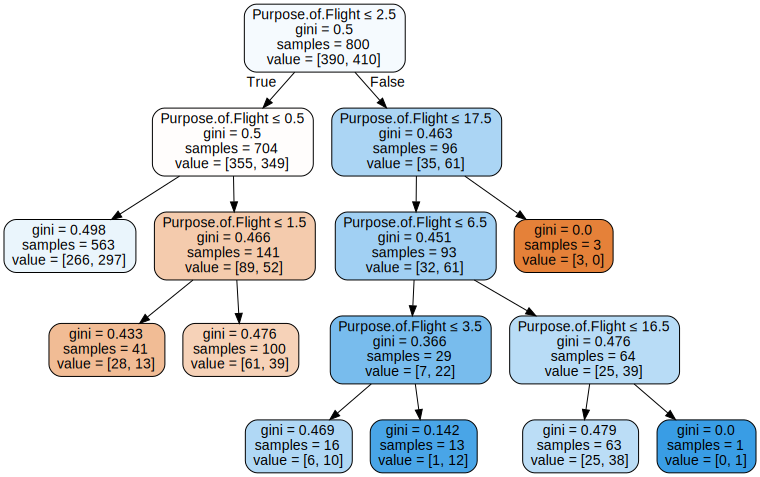

In [ ]:
treedot5 = export_graphviz(dectree5,                                      
                          feature_names = X_train_purposeNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot5)

In [ ]:
damage_train_pred5 = dectree5.predict(X_train_purposeNB)
print("Classification Accuracy: ",dectree5.score(X_train_purposeNB, y_train_injuryNB5))

Classification Accuracy:  0.5625


Amatuer Built


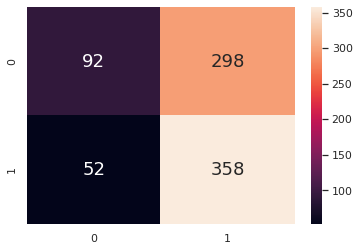

In [ ]:
print("Amatuer Built")
sb.heatmap(confusion_matrix(y_train_injuryNB5,damage_train_pred5),
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
dectree_t5 = DecisionTreeClassifier(max_depth = 4)  
dectree_t5.fit(X_test_purposeNB, y_test_injuryNB5.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

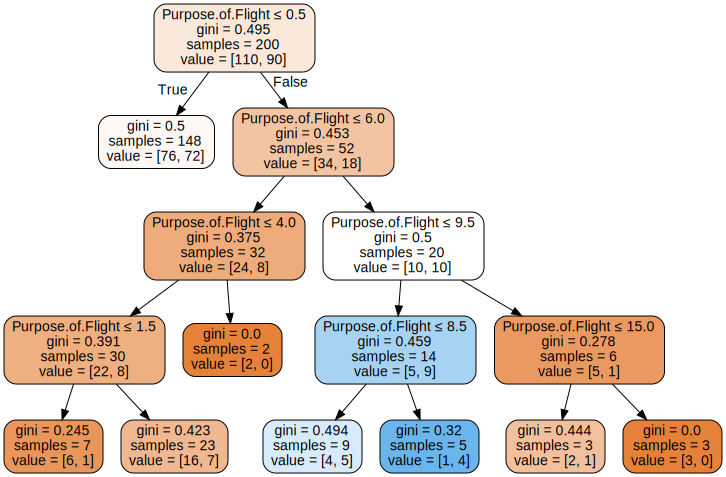

In [ ]:
treedot_t5 = export_graphviz(dectree_t5,                                      
                          feature_names = X_test_purposeNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot_t5)

In [ ]:
damage_test_pred5 = dectree_t5.predict(X_test_purposeNB)
print("Classification Accuracy: ",dectree_t5.score(X_test_purposeNB, y_test_injuryNB5))

Classification Accuracy:  0.57


Amatuer Built Test Data


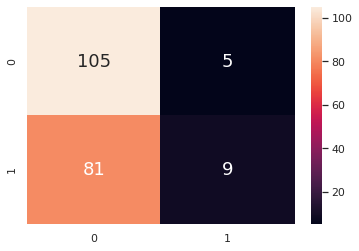

In [ ]:
print("Amatuer Built Test Data")
sb.heatmap(confusion_matrix(y_test_injuryNB5,damage_test_pred5),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Broad Phase of Flight Decision Tree

In [ ]:
dectree6 = DecisionTreeClassifier(max_depth = 4)  
dectree6.fit(X_train_broadNB, y_train_injuryNB6.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

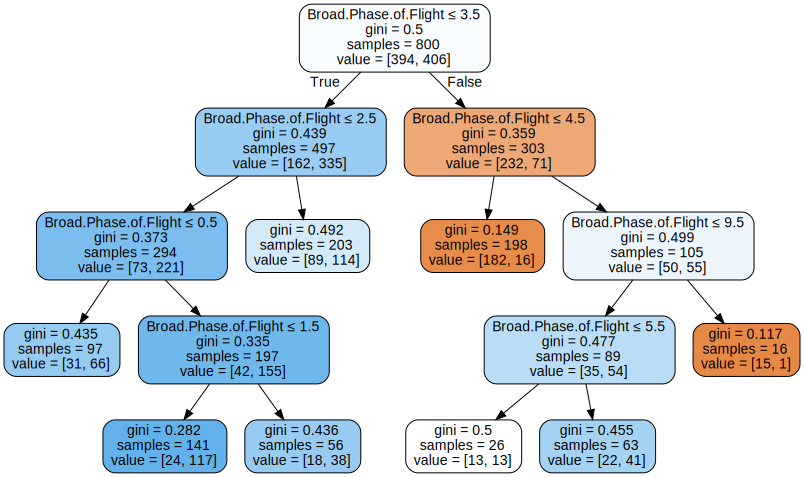

In [ ]:
treedot6 = export_graphviz(dectree6,                                      
                          feature_names = X_train_broadNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot6)

In [ ]:
damage_train_pred6 = dectree6.predict(X_train_broadNB)
print("Classification Accuracy: ",dectree6.score(X_train_broadNB, y_train_injuryNB6))

Classification Accuracy:  0.7325


Amatuer Built


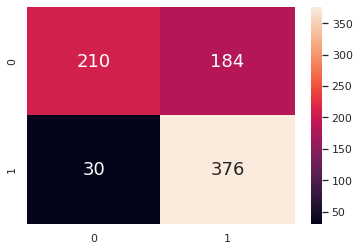

In [ ]:
print("Amatuer Built")
sb.heatmap(confusion_matrix(y_train_injuryNB6,damage_train_pred6),
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
dectree_t6 = DecisionTreeClassifier(max_depth = 4)  
dectree_t6.fit(X_test_broadNB, y_test_injuryNB6.values.ravel()) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

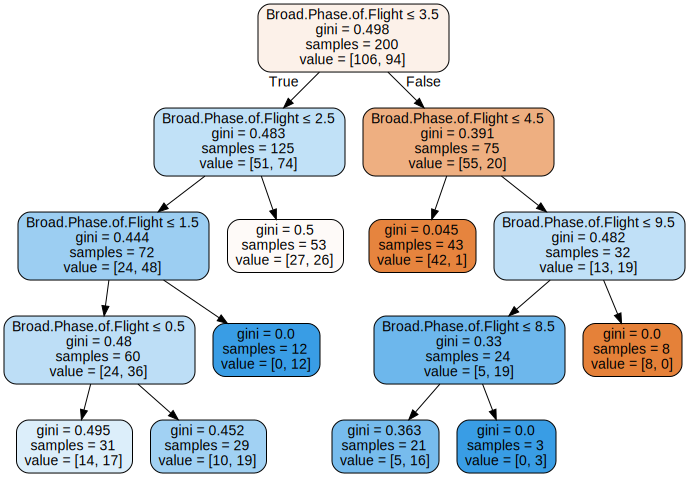

In [ ]:
treedot_t6 = export_graphviz(dectree_t6,                                      
                          feature_names = X_test_broadNB.columns,           
                          out_file = None,                              
                          filled = True,                                
                          rounded = True,                               
                          special_characters = True) 
graphviz.Source(treedot_t6)

In [ ]:
damage_test_pred6 = dectree_t6.predict(X_test_broadNB)
print("Classification Accuracy: ",dectree_t6.score(X_test_broadNB, y_test_injuryNB6))

Classification Accuracy:  0.72


Phase of Flight Test Data


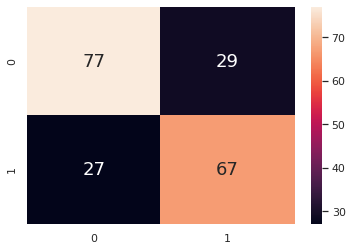

In [ ]:
print("Phase of Flight Test Data")
sb.heatmap(confusion_matrix(y_test_injuryNB6,damage_test_pred6),
           annot = True, fmt=".0f", annot_kws={"size": 18})

SUPPORT VECTOR MACHINE



In [ ]:
x = filterdata.drop('Is.Fatal', axis=1)
y = filterdata['Is.Fatal']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
pred_damage = pd.DataFrame(predictor_num['Aircraft.Damage'])

In [ ]:
weights = {0: 1, 1: 0.75*len(y_train[y_train ==  0])/len(y_train[y_train == 1])}

In [ ]:
x_train_damage,x_test_damage,y_train_damage,y_test_damage = train_test_split(pred_damage,injury_num,test_size = 0.2)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear',class_weight= weights,C = 1) # linear Kernel

#Train the model using the training sets
clf.fit(x_train_damage, y_train_damage.values.ravel())

#Predict the response for test dataset
y_pred_damage = clf.predict(x_test_damage)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_damage, y_pred_damage))

Accuracy: 0.69


In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test_damage, y_pred_damage,zero_division='warn'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test_damage, y_pred_damage,zero_division='warn'))

Precision: 0.9767441860465116
Recall: 0.4077669902912621


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'SVM Decision Region Boundary')

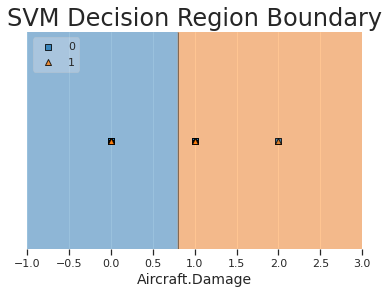

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


# Fit Support Vector Machine Classifier
X_train_plot,X_test_plot,y_train_plot,y_test_plot = train_test_split(pd.DataFrame(predictor_num['Aircraft.Damage']),injury_num.astype(np.integer),test_size = 0.2)


clf = svm.SVC(C = 1,kernel = 'poly')
clf.fit(X_train_plot.values, y_train_plot.values) 

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X_train_plot.values, 
                      y=y_train_plot.values.ravel(),
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel('Aircraft.Damage', size=14)
#plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=24)

Aircraft Damage


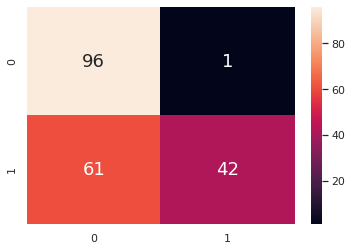

In [ ]:
print("Aircraft Damage")
sb.heatmap(confusion_matrix(y_test_damage,y_pred_damage),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Amateur Built SVM

In [ ]:
pred_built = pd.DataFrame(predictor_num['Amateur.Built'])

In [ ]:
x_train_built,x_test_built,y_train_built,y_test_built = train_test_split(pred_built,injury_num,test_size = 0.2)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear',class_weight= weights,C = 1) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train_built, y_train_built.values.ravel())

#Predict the response for test dataset
y_pred_built = clf.predict(x_test_built)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_built, y_pred_built))

Accuracy: 0.455


In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test_built, y_pred_built,zero_division='warn'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test_built, y_pred_built,zero_division='warn'))

Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Amatuer Built


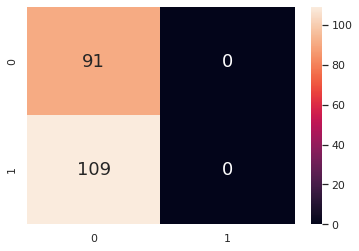

In [ ]:
print("Amatuer Built")
sb.heatmap(confusion_matrix(y_test_built,y_pred_built),
           annot = True, fmt=".0f", annot_kws={"size": 18})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'SVM Decision Region Boundary')

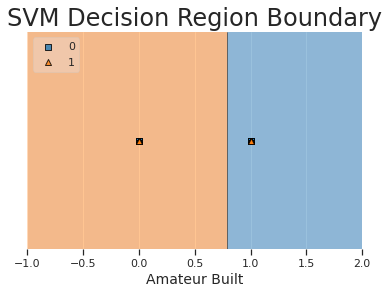

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


# Fit Support Vector Machine Classifier
X_train_plot,X_test_plot,y_train_plot,y_test_plot = train_test_split(pd.DataFrame(predictor_num['Amateur.Built']),injury_num.astype(np.integer),test_size = 0.2)


clf = svm.SVC(C = 1,kernel = 'poly')
clf.fit(X_train_plot.values, y_train_plot.values) 

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X_train_plot.values, 
                      y=y_train_plot.values.ravel(),
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel('Amateur Built', size=14)
#plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=24)

### Weather Condition SVM

In [ ]:
pred_weather = pd.DataFrame(predictor_num['Weather.Condition'])

In [ ]:
x_train_weather,x_test_weather,y_train_weather,y_test_weather = train_test_split(pred_weather,injury_num,test_size = 0.2)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear',class_weight= weights,C = 1) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train_weather, y_train_weather.values.ravel())

#Predict the response for test dataset
y_pred_weather = clf.predict(x_test_weather)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_weather, y_pred_weather))



Accuracy: 0.62


Precision: 0.8636363636363636
Recall: 0.20652173913043478
Weather Condition


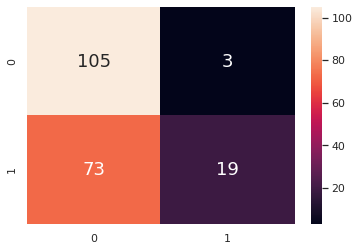

In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test_weather, y_pred_weather,zero_division='warn'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test_weather, y_pred_weather,zero_division='warn'))
print("Weather Condition")
sb.heatmap(confusion_matrix(y_test_weather,y_pred_weather),
           annot = True, fmt=".0f", annot_kws={"size": 18})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'SVM Decision Region Boundary')

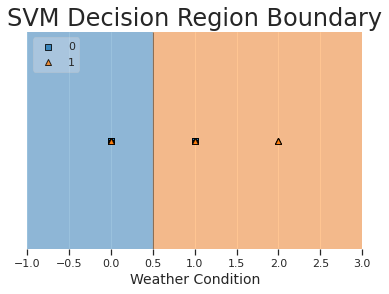

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


# Fit Support Vector Machine Classifier
X_train_plot,X_test_plot,y_train_plot,y_test_plot = train_test_split(pd.DataFrame(predictor_num['Weather.Condition']),injury_num.astype(np.integer),test_size = 0.2)


clf = svm.SVC(C = 100,kernel = 'linear',class_weight= weights)
clf.fit(X_train_plot.values, y_train_plot.values) 

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X_train_plot.values, 
                      y=y_train_plot.values.ravel(),
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel('Weather Condition', size=14)
#plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=24)

### Broad Phase of Flight SVM 

In [ ]:
pred_broad = pd.DataFrame(predictor_num['Broad.Phase.of.Flight'])

In [ ]:
x_train_broad,x_test_broad,y_train_broad,y_test_broad = train_test_split(pred_broad,injury_num,test_size = 0.2)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear',class_weight= weights,C = 1) # Linear Kernel

#Train the model using the training sets
clf.fit(x_train_broad, y_train_broad.values.ravel())

#Predict the response for test dataset
y_pred_broad = clf.predict(x_test_broad)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_broad, y_pred_broad))

Accuracy: 0.63


Precision: 0.7692307692307693
Recall: 0.45871559633027525
Weather Condition


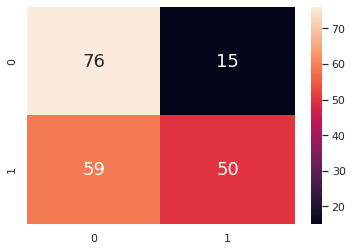

In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test_broad, y_pred_broad,zero_division='warn'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test_broad, y_pred_broad,zero_division='warn'))
print("Weather Condition")
sb.heatmap(confusion_matrix(y_test_broad,y_pred_broad),
           annot = True, fmt=".0f", annot_kws={"size": 18})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'SVM Decision Region Boundary')

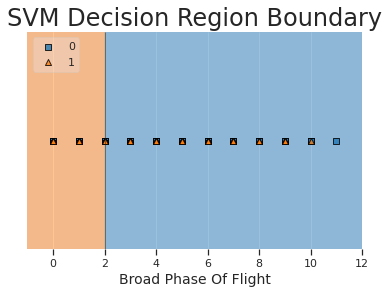

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


# Fit Support Vector Machine Classifier
X_train_plot,X_test_plot,y_train_plot,y_test_plot = train_test_split(pd.DataFrame(predictor_num['Broad.Phase.of.Flight']),injury_num.astype(np.integer),test_size = 0.2)


clf = svm.SVC(C = 100,kernel = 'linear',class_weight= weights)
clf.fit(X_train_plot.values, y_train_plot.values) 

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X_train_plot.values, 
                      y=y_train_plot.values.ravel(),
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel('Broad Phase Of Flight', size=14)
#plt.ylabel(X.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=24)

#Bivariate Analysis (Additional)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'SVM Decision Region Boundary')

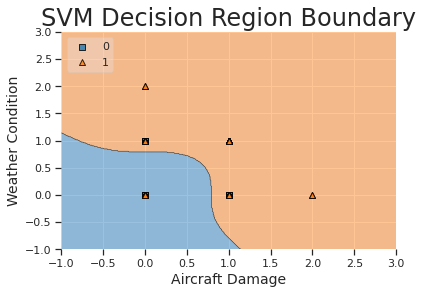

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


# Fit Support Vector Machine Classifier
X_train_plot,X_test_plot,y_train_plot,y_test_plot = train_test_split(pd.DataFrame(predictor_num[['Aircraft.Damage','Weather.Condition']]),injury_num.astype(np.integer),test_size = 0.2)


clf = svm.SVC(C = 1,kernel = 'poly',class_weight= weights)
clf.fit(X_train_plot.values, y_train_plot.values) 

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X_train_plot.values, 
                      y=y_train_plot.values.ravel(),
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.ylabel('Weather Condition', size=14)
plt.xlabel('Aircraft Damage', size=14)
plt.title('SVM Decision Region Boundary', size=24)

We can clearly tell from the various univariate models run that the best univariate predictors are:
1.   Aircraft.Damage
2.   Weather.Condition
3.   List item

# Algorithmic Optimization & Machine Learning (Multivariate Models)

In [ ]:
# preparing data for fitting model (just hijacked the space here, probably got to move this somewhere else)
# note: i added back number of engines and dropped purpose of flight, if you have any objections pls voice it out!!
aviationdata['Injury.Severity'] = aviationdata['Injury.Severity'].astype('category')
aviationdata['Is.Fatal'] = aviationdata['Injury.Severity'].map({"Non-Fatal": 0, "Fatal": 1})
aviationdata['Is.Visual'] = aviationdata['Weather.Condition'].map({"IMC": 0, "VMC": 1, "UNK": 0})
aviationdata['Is.AmBuilt'] = aviationdata['Amateur.Built'].map({"No": 0, "Yes": 1})
aviationdata['Number.of.Engines'] = aviationdata['Number.of.Engines'].astype('int64')

In [ ]:
filterdata = pd.get_dummies(aviationdata, columns=['Aircraft.Damage','Broad.Phase.of.Flight'], prefix=['Damage','Phase'])
filterdata = filterdata.drop(['Injury.Severity','Event.Date','Event.Id','Amateur.Built','Weather.Condition','Purpose.of.Flight'], axis=1)
filterdata

,Latitude,Longitude,Number.of.Engines,index,geometry,month,Is.Fatal,Is.Visual,Is.AmBuilt,Damage_Destroyed,Damage_Minor,Damage_Substantial,Phase_APPROACH,Phase_CLIMB,Phase_CRUISE,Phase_DESCENT,Phase_GO-AROUND,Phase_LANDING,Phase_MANEUVERING,Phase_OTHER,Phase_STANDING,Phase_TAKEOFF,Phase_TAXI,Phase_UNKNOWN
0,17.975278,-66.020834,1,9225,POINT (-66.02083 17.97528),3,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,28.368056,-80.687500,1,8881,POINT (-80.68750 28.36806),6,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,36.419723,-105.287222,1,14162,POINT (-105.28722 36.41972),5,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,46.718056,-94.376111,1,7652,POINT (-94.37611 46.71806),3,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,45.140555,-84.667223,1,16819,POINT (-84.66722 45.14055),10,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.553889,-104.733889,1,11629,POINT (-104.73389 39.55389),8,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
996,30.200000,-95.551389,1,17463,POINT (-95.55139 30.20000),7,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
997,36.048333,-79.474723,2,24095,POINT (-79.47472 36.04833),2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
998,47.083333,-122.466667,2,11558,POINT (-122.46667 47.08333),9,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# tested 2 models with similar accuracy, this first one uses neural networks using tensorflow
%tensorflow_version 1.x
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
x = filterdata.drop('Is.Fatal', axis=1)
y = filterdata['Is.Fatal']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [ ]:
import keras.backend as K
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tensorflow.where(tensorflow.is_nan(f1), tensorflow.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def fpr(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    return fp/(fp+tn)

def fnr(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    return fn/(fn+tp)

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=21))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss=f1_loss, metrics=['binary_accuracy', matthews_correlation, fpr, fnr])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
len(aviationdata[aviationdata['Is.Fatal']==1])/(len(aviationdata[aviationdata['Is.Fatal']==0])+len(aviationdata[aviationdata['Is.Fatal']==1]))

0.5

In [ ]:
  model.fit(x_train, y_train, epochs=200, batch_size=50, class_weight={0: 1, 1: 6})

ValueError: ignored

In [ ]:
y_test_pred = model.predict_classes(x_test)
y_test_pred

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

In [ ]:
# this second one uses standard logistic regression found in sklearn
from sklearn.linear_model import LogisticRegression

In [ ]:
LogReg = LogisticRegression(max_iter=1000)
model = LogReg.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(x_test, y_test)))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

# note the high number of false negatives

In [ ]:
# naive bayes on the set
X = pd.DataFrame(predictor_num[['Aircraft.Damage', 'Amateur.Built', 'Weather.Condition', 'Number.of.Engines', 'Purpose.of.Flight', 'Broad.Phase.of.Flight','month']])
X1, X2, y1, y2 = train_test_split(X , pd.DataFrame(predictor_num['Injury.Severity']), test_size = 0.20)

In [ ]:
print("Multi")
print()
model_multi = CategoricalNB()
model_multi.fit(X1, pd.DataFrame(y1['Injury.Severity']))
y1_pred = model_multi.predict(X1)
y2_pred = model_multi.predict(X2)

print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", accuracy_score(y1, y1_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", accuracy_score(y2, y2_pred))
print()

print(metrics.classification_report(y1, y1_pred))
print(metrics.confusion_matrix(y1, y1_pred))
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y1, y1_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y2, y2_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Statistical Inference & Information Presentation

Something interesting that we were thinking about would be regarding the relationship between Aircraft Damage and Fatality rate.

Are destroyed aircrafts more likely to result in fatalities? Intuitively it would seem so, but let's take a look

In [ ]:
observationdata = pd.DataFrame(aviationdata[['Aircraft.Damage', 'Injury.Severity']])
comparisondata = observationdata[observationdata['Injury.Severity'] == 'Fatal']
sb.countplot(x="Aircraft.Damage", data=comparisondata, palette='bright')

Well, it seems like most of the actual fatalities come from the accidents with substantial damage! But for a better understanding, we should look at the results in proportion (by looking at the fatalities/non-fatalities ratio for each damage type):

In [ ]:
fatality_percent = pd.DataFrame(data=None, index=np.arange(3), columns=["Aircraft Damage", "Fatality Rate (%)"])
damagetype = observationdata['Aircraft.Damage'].unique()
i = 0
for damage in damagetype:
  fatality_percent.loc[i, 'Aircraft Damage'] = damage
  death = comparisondata[comparisondata['Aircraft.Damage'] == damage].count().sum()/2
  total = observationdata[observationdata['Aircraft.Damage'] == damage].count().sum()/2 
  fatality_percent.loc[i, 'Fatality Rate (%)'] = death/total*100
  # we want all the data for the damage, not just the fatalities 
  i += 1

sb.barplot(y="Fatality Rate (%)", x="Aircraft Damage", data=fatality_percent, palette='bright')


This makes much more sense. Here we can easily understand that airplanes that were classified as destroyed in the dataset have a much higher chance of experiencing fatalities

We already know that the majority of airplane Accidents occur during Takeoff and Landing. Another interesting point we thought about relates to the amount of damage caused by accidents at different flight phases. Let's take a look at this!

In [ ]:
observationdata = pd.DataFrame(aviationdata[['Aircraft.Damage', 'Broad.Phase.of.Flight']])
flight_phases = observationdata['Broad.Phase.of.Flight'].unique()
f, axes = plt.subplots(4, 3, figsize=(30, 30))
i = 0
j = 0
count = 0
legend = pd.DataFrame(data=None, index=np.arange(len(flight_phases)), columns=["Phase", "Location"])

for phase in flight_phases:
  comparisondata = observationdata[observationdata['Broad.Phase.of.Flight'] == phase]
  legend.loc[count, 'Phase'] = phase
  legend.loc[count, 'Location'] = (i,j)
  sb.countplot(x="Aircraft.Damage", data=comparisondata, ax=axes[i,j], palette='bright')
  j += 1
  if j == 3:
    i += 1
    j = 0
  count += 1

print(legend)

From this data we can see that takeoff and landing proportionally have the <b>least</b> destructive accidents! Let's take a look at the data once more, but this time from a proportional perspective

In [ ]:
destruction = pd.DataFrame(data=None, index=np.arange(len(flight_phases)), columns=["Phase", "Destroyed (%)"])
count = 0
for phase in flight_phases:
  comparisondata = observationdata[observationdata['Broad.Phase.of.Flight'] == phase]
  base = comparisondata.count().sum()/2
  #print("base is",base)
  destroyed = comparisondata[comparisondata['Aircraft.Damage'] == 'Destroyed'].count().sum()/2
  #print("destroyed is",destroyed)
  destruction.loc[count, 'Phase'] = phase
  destruction.loc[count, 'Destroyed (%)'] = destroyed/base*100
  count += 1

sb.barplot(y="Phase", x="Destroyed (%)", data=destruction, palette='bright')

Here we can see that it's not just about whether the accidents occur more during takeoff or landing - in fact most of the accidents that happen NOT during takeoff or landing tend (more often than not) to be the most destructive (and therefore more fatal)! To verify the increased fatality, let's run the same data as above, but instead of classifying by damage let's do injury severity

In [ ]:
observationdata = pd.DataFrame(aviationdata[['Injury.Severity', 'Broad.Phase.of.Flight']])
destruction = pd.DataFrame(data=None, index=np.arange(len(flight_phases)), columns=["Phase", "Fatality (%)"])
count = 0
for phase in flight_phases:
  comparisondata = observationdata[observationdata['Broad.Phase.of.Flight'] == phase]
  base = comparisondata.count().sum()/2
  #print("base is",base)
  destroyed = comparisondata[comparisondata['Injury.Severity'] == 'Fatal'].count().sum()/2
  #print("destroyed is",destroyed)
  destruction.loc[count, 'Phase'] = phase
  destruction.loc[count, 'Fatality (%)'] = destroyed/base*100
  count += 1

sb.barplot(y="Phase", x="Fatality (%)", data=destruction, palette='bright')

Evidently, the results are quite similar! Proportionally more fatalities take place not during takeoff or landing

In [ ]:
aviationdata.head()